In [1]:
import os, json, numpy as np, random, subprocess
from PIL import Image
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import Normalize

%matplotlib inline

In [2]:
path = "galaxies"

In [12]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer

from photutils import SegmentationImage
from pycocotools.mask import encode

### Convert grayscale images to gray RGB

In [4]:
# files  = ! ls {path}/raw
# norm   = Normalize(vmin=-26.5, vmax=-19)

# for f in files:
    
#     file = fits.open(f"{path}/raw/{f}")
#     img  = file[0].data
#     segm = file[1].data
#     img  = 2.5*np.log10(np.abs(img))
    
#     y, x = img.shape
#     new  = np.zeros((y, x, 3))
    
#     for i in range(3):
#         new[:,:,i] = norm(img, clip=True)
        
#     file.close()
        
#     new = 255*new
#     new = Image.fromarray(np.array(new, dtype=np.uint8))
#     new.save(f"{path}/all/images/{f[:-5]}.jpg")
#     np.save(f"{path}/all/segmaps/{f[:-5]}.npy", segm)

### Make validation set

Split into training and validation:

In [5]:
# ! rm -r {path}/val/images/* {path}/val/segmaps/* {path}/train/images/* {path}/train/segmaps/*

# files  = ! ls {path}/all/segmaps
# files  = [f[:-4] for f in files]
# valset = random.sample(files, int(0.2*len(files)))

# for f in valset:
#     os.system(f"cp {path}/all/segmaps/{f}.npy {path}/val/segmaps/{f}.npy")
#     os.system(f"cp {path}/all/images/{f}.jpg {path}/val/images/{f}.jpg")


# for f in (set(files) - set(valset)):
#     os.system(f"cp {path}/all/segmaps/{f}.npy {path}/train/segmaps/{f}.npy")
#     os.system(f"cp {path}/all/images/{f}.jpg {path}/train/images/{f}.jpg")
    

### Make a Detectron2 dataset registration function

In [6]:
def get_galaxies_dset(dset):
    
    # Files
    files = ! ls {path}/{dset}/images
    files = [f[:-4] for f in files]
#     print(files)
    
    # Dataset dictionaries
    dataset_dicts = []
    
    for idx, f in enumerate(files):
        
        # Data for a single image
        impath = f"{path}/{dset}/images/{f}.jpg"
        imdata = plt.imread(impath)
        
        entry = {}
        entry["file_name"] = impath
        entry["image_id"]  = idx
        entry["height"]    = imdata.shape[0]
        entry["width"]     = imdata.shape[1]
        
        # Annotations
        segmap = np.load(f"{path}/{dset}/segmaps/{f}.npy")
        segmap = SegmentationImage(segmap)
        anns   = []
        for idx, l in enumerate(segmap.labels):
            
            bbox = segmap[idx].bbox
            larr = segmap.data == l
            larr = np.asarray(larr, order="F")
            
            anns.append({
                "bbox" : [bbox.ixmin, bbox.iymin, bbox.ixmax, bbox.iymax],
                "bbox_mode" : BoxMode.XYXY_ABS,
                "segmentation": encode(larr),
                "category_id" : 0
            })
        entry["annotations"] = anns
        dataset_dicts.append(entry)
    return dataset_dicts

Register the train and validation datasets

In [8]:
for d in ["train", "val"]:
#     DatasetCatalog.pop(f"gal_{d}")
    DatasetCatalog.register(f"gal_{d}", lambda d=d: get_galaxies_dset(d))
    MetadataCatalog.get(f"gal_{d}").set(thing_classes=["object"])
    
gal_metadata = MetadataCatalog.get("gal_train")

Look at the output with Detectron API

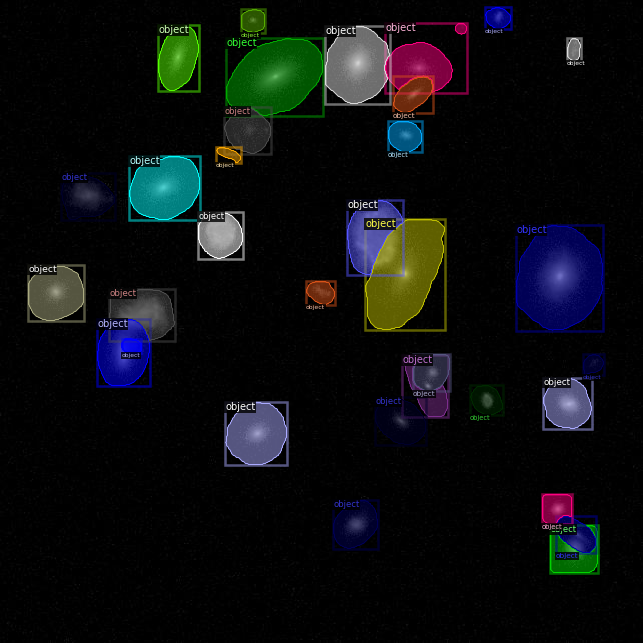

In [13]:
dataset_dicts = get_galaxies_dset("train")

imgs = []
d = random.sample(dataset_dicts, 1)[0]
img        = plt.imread(d["file_name"])
visualizer = Visualizer(img, metadata=gal_metadata, scale=1)
out        = visualizer.draw_dataset_dict(d)
img_labelled = Image.fromarray(out.get_image())
img_labelled

### Train

In [47]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetMapper, build_detection_train_loader, build_detection_test_loader
from detectron2 import model_zoo
import detectron2.data.transforms as T

Get the config file from the pre-trained model

In [48]:
# Initialize the config file
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Datasets
cfg.DATASETS.TRAIN = ("gal_train", )
cfg.DATASETS.TEST = () #no test set
cfg.OUTPUT_DIR     = "galaxies/output"
cfg.INPUT.MASK_FORMAT = "bitmask"

# Loading data 
cfg.DATALOADER.NUM_WORKERS = 2

# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  

# Parameters??
cfg.SOLVER.IMS_PER_BATCH = 5     # Images per batch
cfg.SOLVER.BASE_LR = 0.00025     # Learning rate
cfg.SOLVER.MAX_ITER = 100        # Iterations; need more for real data
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # Batch size - default is 512; this is faster
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

Data loader that allows image augmentation:

In [49]:
dataloader = build_detection_train_loader(cfg,
   mapper=DatasetMapper(cfg, is_train=True, augmentations=[
      T.Resize((800, 800))
   ]))

[12/08 16:05:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [Resize(shape=(800, 800))]
[12/08 16:05:37 d2.data.build]: Removed 0 images with no usable annotations. 240 images left.
[12/08 16:05:37 d2.data.build]: Using training sampler TrainingSampler
[12/08 16:05:37 d2.data.common]: Serializing 240 elements to byte tensors and concatenating them all ...
[12/08 16:05:37 d2.data.common]: Serialized dataset takes 1.42 MiB


In [50]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[12/08 16:06:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/08 16:06:40 d2.data.build]: Removed 0 images with no usable annotations. 240 images left.
[12/08 16:06:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/08 16:06:40 d2.data.build]: Using training sampler TrainingSampler
[12/08 16:06:40 d2.data.common]: Serializing 240 elements to byte tensors and concatenating them all ...
[12/08 16:06:40 d2.data.common]: Serialized dataset takes 1.42 MiB


W1208 16:06:40.608923 140680582043456 checkpoint.py:275] Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
W1208 16:06:40.610140 140680582043456 checkpoint.py:275] Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
W1208 16:06:40.611035 140680582043456 checkpoint.py:275] Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
W1208 16:06:40.611861 140680582043456 checkpoint.py:275] Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (

In [51]:
trainer.train()

[12/08 16:06:41 d2.engine.train_loop]: Starting training from iteration 0


/home/jovyan/.local/lib/python3.6/site-packages/detectron2/data/detection_utils.py:414: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/home/jovyan/.local/lib/python3.6/site-packages/detectron2/data/detection_utils.py:414: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting

[12/08 16:06:54 d2.utils.events]:  eta: 0:00:50  iter: 19  total_loss: 4.279  loss_cls: 0.7193  loss_box_reg: 0.6967  loss_mask: 0.689  loss_rpn_cls: 1.757  loss_rpn_loc: 0.4175  time: 0.6352  data_time: 0.2196  lr: 4.9953e-06  max_mem: 5882M
[12/08 16:07:07 d2.utils.events]:  eta: 0:00:38  iter: 39  total_loss: 3.293  loss_cls: 0.6998  loss_box_reg: 0.7562  loss_mask: 0.6873  loss_rpn_cls: 0.7332  loss_rpn_loc: 0.4041  time: 0.6341  data_time: 0.1972  lr: 9.9902e-06  max_mem: 5918M
[12/08 16:07:19 d2.utils.events]:  eta: 0:00:25  iter: 59  total_loss: 2.833  loss_cls: 0.6509  loss_box_reg: 0.8058  loss_mask: 0.6832  loss_rpn_cls: 0.3254  loss_rpn_loc: 0.3779  time: 0.6289  data_time: 0.1904  lr: 1.4985e-05  max_mem: 5918M
[12/08 16:07:32 d2.utils.events]:  eta: 0:00:12  iter: 79  total_loss: 2.597  loss_cls: 0.5974  loss_box_reg: 0.827  loss_mask: 0.6763  loss_rpn_cls: 0.1694  loss_rpn_loc: 0.3264  time: 0.6311  data_time: 0.2002  lr: 1.998e-05  max_mem: 5918M
[12/08 16:07:47 d2.utils

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir output

In [ ]:
# trainer.

### Results

In [52]:
from detectron2.engine import DefaultPredictor

In [67]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set a custom testing threshold


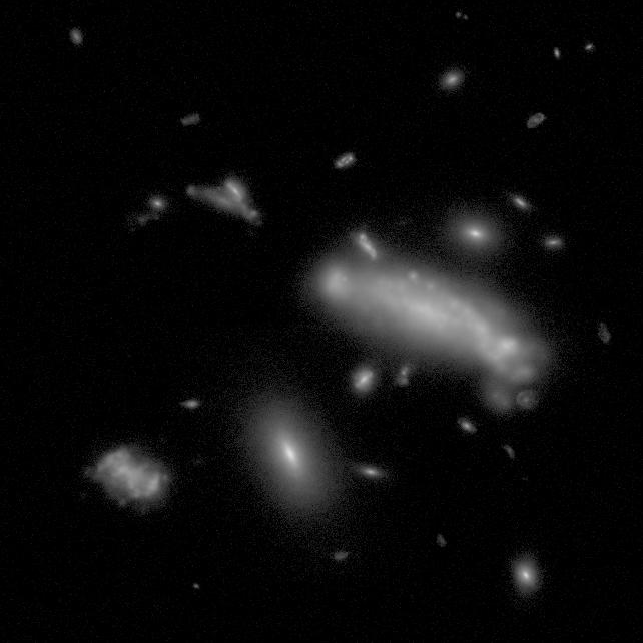

In [68]:
val_dict = get_galaxies_dset("val")
d   = random.sample(dataset_dicts, 1)[0]
im  = plt.imread(d["file_name"])

# im.shape
outputs = predictor(im)
v   = Visualizer(im, metadata=gal_metadata, scale=1)#0.5)#, instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(out.get_image())

In [24]:
from astropy.visualization import AsinhStretch, AsymmetricPercentileInterval

stretch_r = AsinhStretch(1)
stretch_g = AsinhStretch(1)
stretch_b = AsinhStretch(1)

norm_b = AsymmetricPercentileInterval(0.1, 99.9)
norm_g = AsymmetricPercentileInterval(0.1, 99.7)
norm_r = AsymmetricPercentileInterval(0.1, 98.5)

In [25]:
im = plt.imread("galaxies/test/sdss.jpg")
im = im[:,:,0]
r = np.uint8( stretch_r(norm_r(im)) * 255)
g = np.uint8( stretch_g(norm_g(im)) * 255)
b = np.uint8( stretch_b(norm_b(im)) * 255)
            
img    = np.array([r, g, b])
img    = np.swapaxes(img, 0, 2)
img    = np.swapaxes(img, 0, 1)
img.shape

(992, 1014, 3)

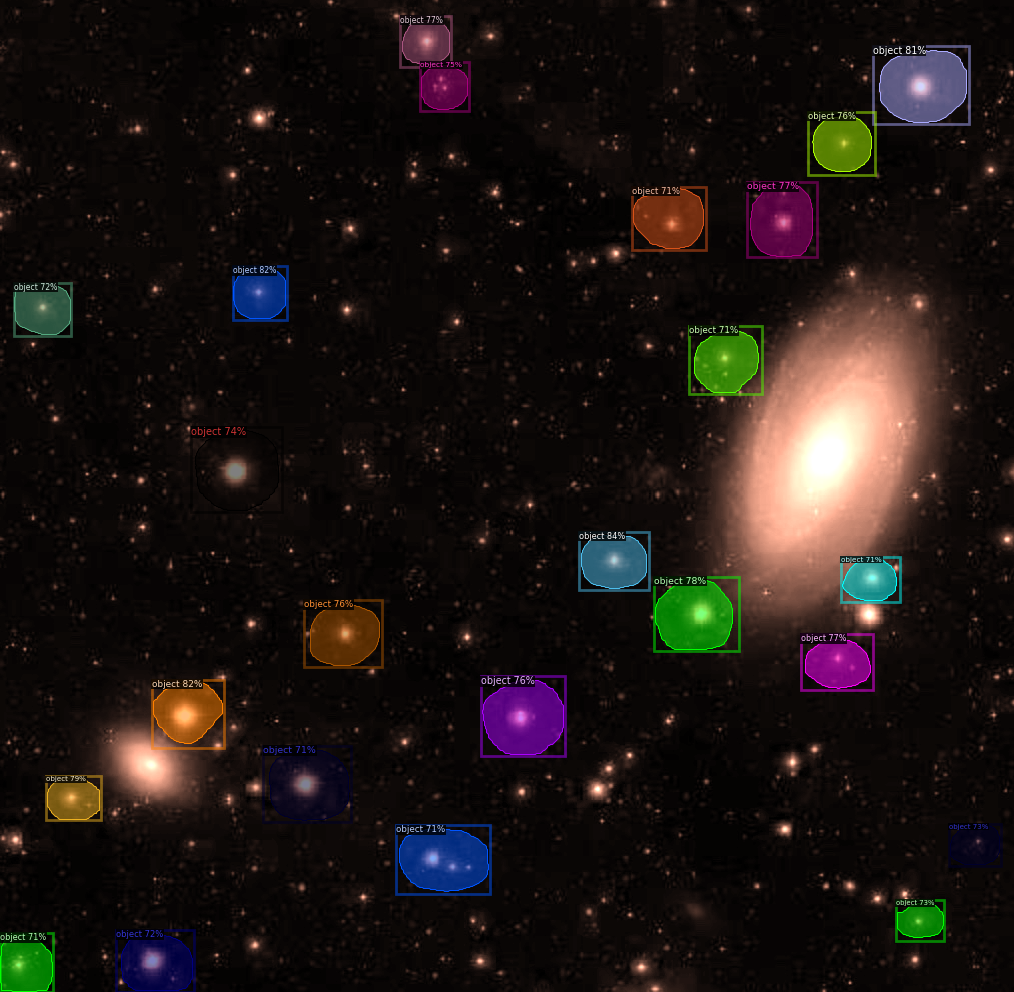

In [26]:
# im = plt.imread("galaxies/test/sdss.jpg")
# d   = random.sample(dataset_dicts, 1)[0]
# im  = plt.imread(d["file_name"])
outputs = predictor(img)
v   = Visualizer(img, metadata=gal_metadata, scale=1)#0.5)#, instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(out.get_image())